In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None, to3d=True, splits=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the column/s where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.loc[:, data_cols].values
    _, seq_len = data.shape
    if to3d: X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    else: 
        assert feat_col is None, 'When feat_col is not None you must set to3d=True'
        X = data
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    if splits is None: return X, y
    else: return split_xy(X, y, splits)


def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]

In [ ]:
#hide
#old
# def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
#export
def SlidingWindow(window_length:int, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
    if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
    get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
    get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
    if horizon == 0 and get_x is not None and get_y is not None:
        assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
        'you need to change either horizon, get_x or get_y to avoid leakage'
    wl = window_length
    ws = wl if stride is None else stride
    start = start if start is not None else np.random.choice(ws, 1)[0]
    def _inner(o):
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            columns = o.columns.values if seq_first else o.T.columns.values
            o = o.values
            if o.ndim > 1: 
                if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
                elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
                else: _get_x = slice(None)
                _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
        elif o.ndim > 1: 
            _get_x = ifnone(get_x, slice(None))
            _get_y = ifnone(get_y, slice(None))
        if seq_first: o = o.T
        o = o.squeeze()
        _seq_len = o.shape[-1]
        assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
        x, y = [], []
        for i in range(start, _seq_len - wl - horizon + 1, ws):
            if o.ndim == 1: 
                x.append(o[..., slice(i, i + wl)])
                if get_y is not None or horizon > 0:
                    if y_func is not None:
                        y.append(y_func(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))]))
                    else: 
                        y.append(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))])
            else: 
                x.append(o[..., _get_x, slice(i, i + wl)])
                if get_y is not None or horizon > 0:
                    if y_func is not None: 
                        y.append(y_func(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i, i + wl))]))
                    else: 
                        y.append(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i + wl - 1, i + wl))])
        X = to3d(stack(x))
        if X.dtype == 'O': X = X.astype(np.float32)
        y = stack(y).squeeze() if y != [] else None
        return X, y
    return _inner

In [ ]:
#export
def SlidingWindowPanel(df, window_length:int, unique_id_cols:list, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True):
    
    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        unique_id_cols  = columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon. If None, get_y will be returned.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
    key = df[unique_id_cols].values
    unique_id_values = df[unique_id_cols].drop_duplicates().values
    _x = []
    _y = []
    for v in unique_id_values: 
        x_v, y_v = SlidingWindow(window_length, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                 horizon=0, seq_first=seq_first)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])
        _x.append(x_v)
        if y_v is not None: _y.append(y_v)
    X = concat(*_x)
    y = concat(*_y) if len(_y) > 0 else None
    return X, y, key

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#6) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),),(array([[5, 6, 7, 8, 9]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, start=None)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[1, 2, 3, 4, 5]]), 6), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[11, 12, 13, 14, 15]]), 16)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


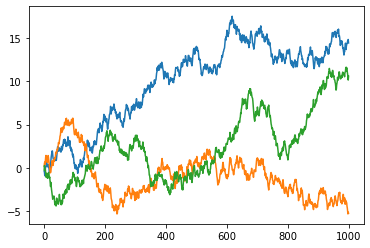

[(array([[-0.36890716, -0.50889262, -0.89858241, -0.43718436, -0.07089062],
       [ 0.21696008,  0.55200481,  0.67929231,  0.42380047,  0.82673184]]), -0.20987049398469337), (array([[0.1567319 , 0.24159572, 0.495267  , 0.91764431, 0.46241032],
       [1.26529347, 1.43989941, 1.23714548, 1.03333084, 0.68522792]]), -1.0371318140853525), (array([[0.13023903, 0.20256659, 0.17222965, 0.35094342, 0.40623455],
       [0.81701165, 0.65892809, 0.935321  , 1.42840154, 1.24436686]]), -0.5355259551282239), (array([[ 0.05322756, -0.06761887, -0.51254565, -0.46608188, -0.06695032],
       [ 0.93235149,  0.66855102,  0.23184431, -0.04373078, -0.25696374]]), -1.4276407427365183), (array([[-0.0940552 ,  0.35869366,  0.81089078,  1.24019166,  1.50184965],
       [-0.56129012, -0.5395354 , -0.46049513, -0.01578611,  0.0649467 ]]), -2.4527035906218684), (array([[1.68054755, 1.95011202, 1.96128392, 1.60267253, 1.16949478],
       [0.38367748, 0.82613705, 0.6517286 , 0.61098866, 0.28817567]]), -3.300145027

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,0.428650,-0.326963,-0.085575
1,0.284065,-0.311630,-0.302043
2,0.104455,-0.545931,-0.298127
3,0.549619,-0.959028,-0.473959
4,0.960565,-1.396995,-0.190061
...,...,...,...
95,1.729442,1.011776,0.250925
96,1.744475,1.386912,-0.180866
97,1.920023,1.744598,-0.356057
98,1.588094,1.807103,-0.213405


[(array([[ 0.42864955,  0.28406494,  0.10445536,  0.54961878,  0.96056463],
       [-0.3269632 , -0.31162957, -0.54593075, -0.9590282 , -1.39699459]]), -0.19006057848381452), (array([[ 0.28406494,  0.10445536,  0.54961878,  0.96056463,  0.4690714 ],
       [-0.31162957, -0.54593075, -0.9590282 , -1.39699459, -1.33349068]]), 0.13138592117451375), (array([[ 0.10445536,  0.54961878,  0.96056463,  0.4690714 ,  0.01104147],
       [-0.54593075, -0.9590282 , -1.39699459, -1.33349068, -1.68012295]]), 0.1233142999785144), (array([[ 0.54961878,  0.96056463,  0.4690714 ,  0.01104147,  0.45624074],
       [-0.9590282 , -1.39699459, -1.33349068, -1.68012295, -1.89628934]]), 0.3092674808554001), (array([[ 0.96056463,  0.4690714 ,  0.01104147,  0.45624074,  0.90853367],
       [-1.39699459, -1.33349068, -1.68012295, -1.89628934, -2.26209561]]), 0.631429941127437), (array([[ 0.4690714 ,  0.01104147,  0.45624074,  0.90853367,  1.11145492],
       [-1.33349068, -1.68012295, -1.89628934, -2.26209561, -2

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.149651,-0.057757,-0.240581,-0.260858,-0.035769
1,-0.523912,-0.404033,-0.427987,-0.290378,-0.226340
2,-0.964087,0.077438,-0.622017,-0.163944,-0.530410
3,-0.779972,-0.197371,-0.491060,-0.079882,-0.159196
4,-0.622851,-0.080156,-0.464296,-0.507590,-0.136472
...,...,...,...,...,...
95,-2.752898,4.536374,-2.470318,1.557789,2.395942
96,-2.743326,4.998638,-2.573264,2.052519,2.187018
97,-3.000157,4.738767,-3.001943,2.209604,1.714881
98,-3.230359,4.312958,-3.341920,1.721330,1.236332


[(array([[-0.14965143, -0.52391189, -0.9640869 , -0.77997204, -0.62285093],
       [-0.05775723, -0.40403291,  0.07743802, -0.1973709 , -0.08015594],
       [-0.240581  , -0.42798651, -0.62201676, -0.49106   , -0.46429562],
       [-0.26085798, -0.29037799, -0.16394362, -0.07988205, -0.50759003]]), -0.13647223852063517), (array([[-0.52391189, -0.9640869 , -0.77997204, -0.62285093, -0.24847807],
       [-0.40403291,  0.07743802, -0.1973709 , -0.08015594,  0.09545135],
       [-0.42798651, -0.62201676, -0.49106   , -0.46429562, -0.22890598],
       [-0.29037799, -0.16394362, -0.07988205, -0.50759003, -0.01911803]]), 0.2699879595051352), (array([[-0.9640869 , -0.77997204, -0.62285093, -0.24847807,  0.10644309],
       [ 0.07743802, -0.1973709 , -0.08015594,  0.09545135, -0.29241397],
       [-0.62201676, -0.49106   , -0.46429562, -0.22890598, -0.57566166],
       [-0.16394362, -0.07988205, -0.50759003, -0.01911803, -0.25432295]]), -0.0835834761776616), (array([[-0.77997204, -0.62285093, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.389454,-0.209351,0.090077,-0.121859,-0.431750,-0.717721,-1.060622,-0.717771,-0.501526,-0.274531,...,-0.378983,-0.830155,-0.634403,-0.185002,-0.330601,-0.733931,-0.704602,-1.083308,-1.166870,-1.579098
var_1,0.296415,0.316386,0.031277,-0.150829,0.156899,-0.217180,0.012903,0.417320,0.796492,1.180924,...,1.643012,1.970105,1.638468,1.564324,1.246091,1.670667,1.398281,1.760838,2.063927,2.515893
var_2,0.128478,0.407957,0.445817,0.452591,0.288474,0.524195,0.169586,0.107396,0.514318,0.175352,...,2.935587,2.468327,2.464742,2.711652,2.213109,2.364716,2.416106,2.849822,3.008853,2.684767
var_3,0.384205,0.224525,-0.241933,-0.173835,-0.125113,-0.571412,-0.313909,-0.334356,-0.708905,-0.958307,...,-1.176121,-0.891568,-1.242326,-1.027076,-1.389036,-1.788488,-1.847897,-2.199428,-2.200063,-2.491956
target,-0.473406,-0.194220,0.066137,0.557304,0.456957,0.024931,0.226758,0.001072,-0.239066,0.236308,...,2.072342,2.509068,2.280584,2.469246,2.825260,2.637589,3.119163,2.707915,2.706050,2.591070


[(array([[-0.38945418, -0.20935086,  0.09007729, -0.12185903, -0.43174973],
       [ 0.29641528,  0.31638563,  0.03127741, -0.1508292 ,  0.15689856],
       [ 0.12847789,  0.40795739,  0.44581701,  0.4525909 ,  0.28847369],
       [ 0.3842054 ,  0.22452483, -0.24193347, -0.17383462, -0.12511286]]), 0.4569569132145558), (array([[-0.20935086,  0.09007729, -0.12185903, -0.43174973, -0.71772139],
       [ 0.31638563,  0.03127741, -0.1508292 ,  0.15689856, -0.21717952],
       [ 0.40795739,  0.44581701,  0.4525909 ,  0.28847369,  0.52419498],
       [ 0.22452483, -0.24193347, -0.17383462, -0.12511286, -0.57141231]]), 0.024930823753478215), (array([[ 0.09007729, -0.12185903, -0.43174973, -0.71772139, -1.06062244],
       [ 0.03127741, -0.1508292 ,  0.15689856, -0.21717952,  0.01290251],
       [ 0.44581701,  0.4525909 ,  0.28847369,  0.52419498,  0.16958611],
       [-0.24193347, -0.17383462, -0.12511286, -0.57141231, -0.31390922]]), 0.22675836765794344), (array([[-0.12185903, -0.43174973, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.443084,-0.858282,-1.078370,-0.899508,-0.736605,-0.692698,-1.027889,-1.165064,-0.793680,-1.085331,...,-0.760420,-0.718263,-1.187311,-0.897079,-1.375833,-1.088646,-1.300266,-1.222240,-0.976601,-0.833116
var_1,-0.294674,-0.118488,-0.008186,-0.096062,-0.380247,-0.558092,-0.688150,-0.890505,-0.410693,-0.509327,...,0.276009,0.233393,0.637767,0.825455,1.305083,1.091583,0.628034,1.048465,1.063765,0.993335
var_2,0.260753,0.165456,0.178182,-0.138536,0.282385,0.537220,0.715874,0.757428,0.451060,0.678630,...,2.493266,2.720153,2.741865,3.042669,2.722778,2.368217,2.382069,2.469528,2.746448,2.263383
var_3,-0.034979,-0.284075,-0.701694,-0.287082,-0.120385,0.345249,-0.009052,-0.049762,-0.443771,-0.917366,...,-0.115200,0.005703,-0.056498,-0.403338,-0.380170,-0.853264,-1.226503,-1.466156,-1.698873,-2.076963
target,-0.361600,-0.361145,-0.437553,-0.769262,-0.355576,-0.710361,-0.394813,-0.174355,0.267958,0.372388,...,1.878590,1.429687,1.719081,2.051363,1.660578,1.945603,1.954315,2.449862,2.342050,2.741372


[(array([[-0.44308381, -0.85828176, -1.07836985, -0.89950783, -0.73660494],
       [-0.29467398, -0.11848786, -0.00818598, -0.09606189, -0.38024716],
       [ 0.26075257,  0.16545592,  0.17818219, -0.13853551,  0.28238468],
       [-0.03497888, -0.28407544, -0.70169359, -0.2870816 , -0.1203846 ]]), -0.35557628144688624), (array([[-0.69269758, -1.02788872, -1.16506386, -0.79367962, -1.08533095],
       [-0.55809246, -0.68815002, -0.89050503, -0.41069332, -0.50932703],
       [ 0.53721959,  0.71587417,  0.75742751,  0.4510598 ,  0.67863015],
       [ 0.34524918, -0.00905159, -0.04976178, -0.44377139, -0.91736612]]), 0.3723875351936592), (array([[-1.09803014, -1.01576124, -1.34279977, -0.92573809, -0.67404563],
       [-0.13018968, -0.38253215, -0.71115906, -0.60045574, -0.47963995],
       [ 0.35796222,  0.84239241,  0.54087313,  0.63495053,  1.11473971],
       [-0.51784294, -0.23203086, -0.71394244, -0.91819314, -0.7459622 ]]), -0.017940484405697954), (array([[-0.56330095, -0.95486831,

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.359875,0.141858,-0.007355,0.438403,0.182480
1,-0.064441,-0.120648,-0.432625,0.803913,-0.028188
2,0.202540,0.184735,-0.925101,0.379194,0.027388
3,-0.157562,0.153334,-1.305702,0.470255,-0.038896
4,0.156408,-0.283923,-1.409658,0.074870,-0.006637
...,...,...,...,...,...
95,0.782386,-1.386488,-0.068122,-3.089713,-1.091294
96,1.128397,-0.895270,-0.556625,-2.955799,-0.842763
97,1.405237,-0.888228,-0.855888,-3.186031,-1.218684
98,1.508717,-1.291283,-1.270629,-3.311362,-1.449170


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(20)]).T * tensor([1, 10, 100]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(20)
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df = df.append(df2).append(df3).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,var_0,var_1,var_2,time,device,target
0,12,120,1200,12,0,1
1,5,41,401,4,1,2
2,17,152,1502,15,2,2
3,9,90,900,9,0,1
4,5,32,302,3,2,3
5,19,181,1801,18,1,2
6,5,50,500,5,0,1
7,20,191,1901,19,1,1
8,15,150,1500,15,0,0
9,10,100,1000,10,0,1


In [ ]:
X, y, key = SlidingWindowPanel(df, 5, unique_id_cols=['device'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True)

X.shape, y.shape, key.shape

((48, 3, 5), (48,), (60, 1))

In [ ]:
X, y, key = SlidingWindowPanel(df, 5, unique_id_cols=['device'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                               y_func=lambda o: np.mean(o), horizon=0, seq_first=True, sort_by=['time'], ascending=True)
X.shape, y.shape, key.shape

((48, 3, 5), (48,), (60, 1))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models.FCNPlus.ipynb.
Converted 104_models.